In [4]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce
%matplotlib inline
np.random.seed(42)

In [4]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [6]:
X_train, Y_train, X_test, Y_test = load()

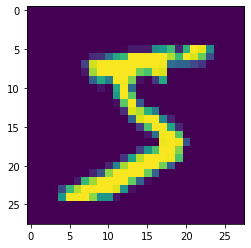

In [15]:
plt.imshow(X_train[0].reshape(28,28))

In [16]:
class FC:
    def __init__(self, in_channel, out_channel):
        self.W = {'val': np.random.normal(0,1,(in_channel,out_channel)), 'grad': 0}
        self.b = {'val': np.random.randn(out_channel), 'grad': 0}
        self.cache = None
    
    def forward(self, X):
        out = np.dot(X, self.W) + self.b
        self.cache = X
        return out
    
    def backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        self.update()
        return dX
    
    def update(self, lr=0.001):
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

In [2]:
class Conv2D():
    def __init__(self, shape, output_channels, ksize=3, stride=1, method='VALID'):
        self.input_shape = shape
        self.output_channels = output_channels
        self.input_channels = shape[-1]
        self.batchsize = shape[0]
        self.stride = stride
        self.ksize = ksize
        self.method = method

        weights_scale = math.sqrt(reduce(lambda x, y: x * y, shape) / self.output_channels)
        self.weights = np.random.standard_normal(
            (ksize, ksize, self.input_channels, self.output_channels)) / weights_scale
        self.bias = np.random.standard_normal(self.output_channels) / weights_scale

        if method == 'VALID':
            self.eta = np.zeros((shape[0], (shape[1] - ksize + 1) / self.stride, (shape[1] - ksize + 1) / self.stride,
             self.output_channels))

        if method == 'SAME':
            self.eta = np.zeros((shape[0], shape[1]/self.stride, shape[2]/self.stride,self.output_channels))

        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        self.output_shape = self.eta.shape

        if (shape[1] - ksize) % stride != 0:
            print('input tensor width can\'t fit stride')
        if (shape[2] - ksize) % stride != 0:
            print('input tensor height can\'t fit stride')

    def forward(self, x):
        col_weights = self.weights.reshape([-1, self.output_channels])
        if self.method == 'SAME':
            x = np.pad(x, (
                (0, 0), (self.ksize / 2, self.ksize / 2), (self.ksize / 2, self.ksize / 2), (0, 0)),
                             'constant', constant_values=0)

        self.col_image = []
        conv_out = np.zeros(self.eta.shape)
        for i in range(self.batchsize):
            img_i = x[i][np.newaxis, :]
            self.col_image_i = im2col(img_i, self.ksize, self.stride)
            conv_out[i] = np.reshape(np.dot(self.col_image_i, col_weights) + self.bias, self.eta[0].shape)
            self.col_image.append(self.col_image_i)
        self.col_image = np.array(self.col_image)
        return conv_out

    def gradient(self, eta):
        self.eta = eta
        col_eta = np.reshape(eta, [self.batchsize, -1, self.output_channels])

        for i in range(self.batchsize):
            self.w_gradient += np.dot(self.col_image[i].T, col_eta[i]).reshape(self.weights.shape)
        self.b_gradient += np.sum(col_eta, axis=(0, 1))

        # deconv of padded eta with flippd kernel to get next_eta
        if self.method == 'VALID':
            pad_eta = np.pad(self.eta, (
                (0, 0), (self.ksize - 1, self.ksize - 1), (self.ksize - 1, self.ksize - 1), (0, 0)),
                             'constant', constant_values=0)

        if self.method == 'SAME':
            pad_eta = np.pad(self.eta, (
                (0, 0), (self.ksize / 2, self.ksize / 2), (self.ksize / 2, self.ksize / 2), (0, 0)),
                             'constant', constant_values=0)

        flip_weights = np.flipud(np.fliplr(self.weights))
        flip_weights = flip_weights.swapaxes(2, 3)
        col_flip_weights = flip_weights.reshape([-1, self.input_channels])
        col_pad_eta = np.array([im2col(pad_eta[i][np.newaxis, :], self.ksize, self.stride) for i in range(self.batchsize)])
        next_eta = np.dot(col_pad_eta, col_flip_weights)
        next_eta = np.reshape(next_eta, self.input_shape)
        return next_eta

    def backward(self, alpha=0.00001, weight_decay=0.0004):
        # weight_decay = L2 regularization
        self.weights *= (1 - weight_decay)
        self.bias *= (1 - weight_decay)
        self.weights -= alpha * self.w_gradient
        self.bias -= alpha * self.bias

        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)



def im2col(image, ksize, stride):
    # image is a 4d tensor([batchsize, width ,height, channel])
    image_col = []
    for i in range(0, image.shape[1] - ksize + 1, stride):
        for j in range(0, image.shape[2] - ksize + 1, stride):
            col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
            image_col.append(col)
    image_col = np.array(image_col)

    return image_col

In [18]:
class MaxPool2d:
    pass

In [27]:
np.random.randn(5)

array([-0.46063877,  1.05712223,  0.34361829, -1.76304016,  0.32408397])